### 泉岡先輩指導のもと、基本的なEDA（Exploratory Data Analysis）から前処理とちょっとしたモデリングまでを頑張ってみましょう。

参考記事：https://qiita.com/masa26hiro/items/ce5f60e2950e072a0910

↑先ずは一読

↓これは気にしないで（僕のJupyterは改造してあって、これがないと図が汚くなってしまう--;）

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
custom_style = {'axes.labelcolor': 'black',
                'xtick.color': 'black',
                'ytick.color': 'black'}
sns.set_style("darkgrid", rc=custom_style)

1.準備¶
２.EDA開始¶


## 1.準備

↓後ほど使うものを、全てインストール

In [42]:
#分析・集計に使うモジュールとライブラリ
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import seaborn as sns

#各種機械学習モデル
#LogisticRegression
from sklearn.linear_model import LogisticRegression
#Linear Support Vector Machine
from sklearn.svm import LinearSVC
#Support Vector Machine
from sklearn.svm import SVC
#決定木
from sklearn.tree import DecisionTreeClassifier
#ランダムフォレスト
from sklearn.ensemble import RandomForestClassifier
#k近傍方（k-neighbor）
from sklearn.neighbors import KNeighborsClassifier

#学習方法（GridSearchCV）
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

#スコアリング（f値）
from sklearn.metrics import f1_score

import lightgbm as lgb
import pandas_profiling as pdp


#### データの読み込み

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


- PassengerId – 乗客識別ユニークID
- Survived – 生存フラグ（0=死亡、1=生存）
- Pclass – チケットクラス
- Name – 乗客の名前
- Sex – 性別（male=男性、female＝女性）
- Age – 年齢
- SibSp – タイタニックに同乗している兄弟/配偶者の数
- Parch – タイタニックに同乗している親/子供の数
- Ticket – チケット番号
- Fare – 料金
- Cabin – 客室番号
- Embarked – 出港地（タイタニックへ乗った港）

## ２.EDA開始

↓欠損値調査の関数

In [4]:
def kesson_table(df):
    null_val = df.isnull().sum()
    percent = 100 * df.isnull().sum()/len(df)
    kesson_table = pd.concat([null_val,percent],axis=1)
    kesson_table_ren_columns = kesson_table.rename(columns = {0:'lack num',1:'%'})
    return kesson_table_ren_columns

↓先ずはdescribe()で各データの基礎集計値見ようぜべいべ〜

In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


！！！　応用編としてpandas_profiling使ってみるとこんな感じ

In [6]:
pdp.ProfileReport(train)

Number of variables,12
Number of observations,891
Total Missing (%),8.1%
Total size in memory,83.6 KiB
Average record size in memory,96.1 B
Numeric,6
Categorical,4
Boolean,1
Date,0
Text (Unique),1
Rejected,0


#### 欠損値の確認

In [7]:
kesson_table(train)

,lack num,%
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
Age,177,19.865320
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000
Fare,0,0.000000


↑Ageの欠損値多いっすね

#### 性別毎の運賃:min,max,mean,median,stdをみたい

最初にFareの分布をみてみる↓

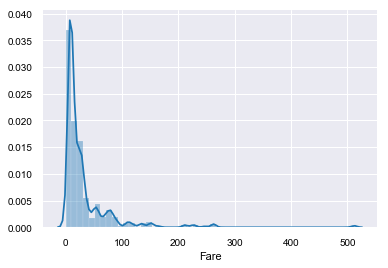

In [45]:
sns.distplot(train["Fare"])

...ふむふむ。よしこれを男女別に見てみよう！！！

In [46]:
#データを男女別に！
#men_only_train
m_train = train[train["Sex"]=="male"]
#women_only_train
w_train = train[train["Sex"]=="female"]

In [47]:
#men運賃
m_train["Fare"].median()

10.5

In [48]:
#women運賃
w_train["Fare"].median()

23.0

In [49]:
#men_only_trainの基礎集計値
m_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,577.000000,577.000000,577.000000,453.000000,577.000000,577.000000,577.000000
mean,454.147314,0.188908,2.389948,30.726645,0.429809,0.235702,25.523893
std,257.486139,0.391775,0.813580,14.678201,1.061811,0.612294,43.138263
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,464.000000,0.000000,3.000000,29.000000,0.000000,0.000000,10.500000
75%,680.000000,0.000000,3.000000,39.000000,0.000000,0.000000,26.550000
max,891.000000,1.000000,3.000000,80.000000,8.000000,5.000000,512.329200


In [50]:
#women_only_trainの基礎集計値
w_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,314.000000,314.000000,314.000000,261.000000,314.000000,314.000000,314.000000
mean,431.028662,0.742038,2.159236,27.915709,0.694268,0.649682,44.479818
std,256.846324,0.438211,0.857290,14.110146,1.156520,1.022846,57.997698
min,2.000000,0.000000,1.000000,0.750000,0.000000,0.000000,6.750000
25%,231.750000,0.000000,1.000000,18.000000,0.000000,0.000000,12.071875
50%,414.500000,1.000000,2.000000,27.000000,0.000000,0.000000,23.000000
75%,641.250000,1.000000,3.000000,37.000000,1.000000,1.000000,55.000000
max,889.000000,1.000000,3.000000,63.000000,8.000000,6.000000,512.329200


In [51]:
#trainのFareをSex毎に集計
train.groupby('Sex').agg({'Fare': ['min', 'max', 'mean', 'median', 'std']})
#↑と同じ↓
#train.groupby('Sex').aggregate([min,max,np.mean,np.median,np.std])['Fare']

Fare                                       
         min       max       mean median        std
Sex                                                
female  6.75  512.3292  44.479818   23.0  57.997698
male    0.00  512.3292  25.523893   10.5  43.138263

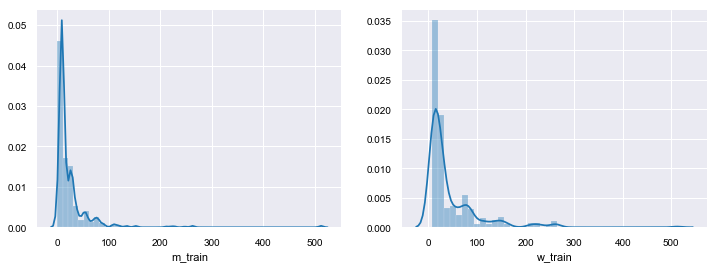

In [52]:
fig,(ax1, ax2) = plt.subplots(1, 2,figsize=(12, 4))
sns.distplot(m_train["Fare"],ax=ax1,axlabel="m_train")
sns.distplot(w_train["Fare"],ax=ax2,axlabel="w_train")

fare_trainを定義すればこんなこと↓もできる

In [53]:
fare_train = pd.DataFrame({"Sex":train["Sex"],
                           "Fare":train["Fare"]})
fare_train.shape

(891, 2)

In [54]:
fare_train.groupby("Sex").aggregate([min,max,np.mean,np.median,np.std])

Fare                                       
         min       max       mean median        std
Sex                                                
female  6.75  512.3292  44.479818   23.0  57.997698
male    0.00  512.3292  25.523893   10.5  43.138263

#### 今度は年代別の運賃:min,max,mean,median,std

In [55]:
#年代別columnをby_ageとする
train['by_age'] = pd.cut(train['Age'], np.arange(0, 90, 10))
#↓こっちは欠損値をおとさないと計算できないッチャ
#train['by_age'] = (train["Age"]/10).astype(int)*10
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,by_age
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,"(20, 30]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,"(30, 40]"
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,"(20, 30]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,"(30, 40]"
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,"(30, 40]"


### こっからは色々条件絞ってたくさん見ていくなり！！

In [56]:
sorted(train["Ticket"].unique())

['110152',
 '110413',
 '110465',
 '110564',
 '110813',
 '111240',
 '111320',
 '111361',
 '111369',
 '111426',
 '111427',
 '111428',
 '112050',
 '112052',
 '112053',
 '112058',
 '112059',
 '112277',
 '112379',
 '113028',
 '113043',
 '113050',
 '113051',
 '113055',
 '113056',
 '113059',
 '113501',
 '113503',
 '113505',
 '113509',
 '113510',
 '113514',
 '113572',
 '113760',
 '113767',
 '113773',
 '113776',
 '113781',
 '113783',
 '113784',
 '113786',
 '113787',
 '113788',
 '113789',
 '113792',
 '113794',
 '113796',
 '113798',
 '113800',
 '113803',
 '113804',
 '113806',
 '113807',
 '11668',
 '11751',
 '11752',
 '11753',
 '11755',
 '11765',
 '11767',
 '11769',
 '11771',
 '11774',
 '11813',
 '11967',
 '12233',
 '12460',
 '12749',
 '13049',
 '13213',
 '13214',
 '13502',
 '13507',
 '13509',
 '13567',
 '13568',
 '14311',
 '14312',
 '14313',
 '14973',
 '1601',
 '16966',
 '16988',
 '17421',
 '17453',
 '17463',
 '17464',
 '17465',
 '17466',
 '17474',
 '17764',
 '19877',
 '19928',
 '19943',
 '19947'

↑組み込み関数sorted()とリスト型のメソッドsort()には注意！！！！！！
https://note.nkmk.me/python-list-sort-sorted/

In [57]:
#とりあえず見てみる！
display(train[train['Ticket'] == 'LINE'],
        train[train['Ticket'].str.startswith('112')],
        train[train['Ticket'].str.startswith('117')],
        train[(train['Fare'] == 0)])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,by_age
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S,"(30, 40]"
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S,"(20, 30]"
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S,"(10, 20]"
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S,"(40, 50]"


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,by_age
209,210,1,1,"Blank, Mr. Henry",male,40.0,0,0,112277,31.0,A31,C,"(30.0, 40.0]"
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S,"(30.0, 40.0]"
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S,NaN
766,767,0,1,"Brewe, Dr. Arthur Jackson",male,NaN,0,0,112379,39.6,NaN,C,NaN
806,807,0,1,"Andrews, Mr. Thomas Jr",male,39.0,0,0,112050,0.0,A36,S,"(30.0, 40.0]"
815,816,0,1,"Fry, Mr. Richard",male,NaN,0,0,112058,0.0,B102,S,NaN
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0,B42,S,"(10.0, 20.0]"


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,by_age
136,137,1,1,"Newsom, Miss. Helen Monypeny",female,19.0,0,2,11752,26.2833,D47,S,"(10.0, 20.0]"
248,249,1,1,"Beckwith, Mr. Richard Leonard",male,37.0,1,1,11751,52.5542,D35,S,"(30.0, 40.0]"
310,311,1,1,"Hays, Miss. Margaret Bechstein",female,24.0,0,0,11767,83.1583,C54,C,"(20.0, 30.0]"
370,371,1,1,"Harder, Mr. George Achilles",male,25.0,1,0,11765,55.4417,E50,C,"(20.0, 30.0]"
487,488,0,1,"Kent, Mr. Edward Austin",male,58.0,0,0,11771,29.7000,B37,C,"(50.0, 60.0]"
556,557,1,1,"Duff Gordon, Lady. (Lucille Christiana Sutherl...",female,48.0,1,0,11755,39.6000,A16,C,"(40.0, 50.0]"
571,572,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0,2,0,11769,51.4792,C101,S,"(50.0, 60.0]"
621,622,1,1,"Kimball, Mr. Edwin Nelson Jr",male,42.0,1,0,11753,52.5542,D19,S,"(40.0, 50.0]"
839,840,1,1,"Marechal, Mr. Pierre",male,NaN,0,0,11774,29.7000,C47,C,NaN
871,872,1,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,D35,S,"(40.0, 50.0]"


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,by_age
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S,"(30.0, 40.0]"
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S,"(30.0, 40.0]"
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S,"(20.0, 30.0]"
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S,NaN
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S,"(10.0, 20.0]"
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S,NaN
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S,NaN
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S,NaN
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S,"(40.0, 50.0]"
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S,NaN


In [58]:
train.groupby("by_age").agg({'Fare': ['min', 'max', 'mean', 'median', 'std']})

Fare                                         
             min       max       mean   median        std
by_age                                                   
(0, 10]   8.5167  151.5500  30.434439  27.0000  24.807302
(10, 20]  0.0000  263.0000  29.529531  10.1708  48.205761
(20, 30]  0.0000  263.0000  28.306719  11.9250  43.932668
(30, 40]  0.0000  512.3292  42.496100  20.2500  76.412642
(40, 50]  0.0000  247.5208  41.163181  26.0000  48.449521
(50, 60]  7.0542  153.4625  44.774802  30.1000  37.412638
(60, 70]  6.2375  263.0000  45.910782  26.5500  61.326763
(70, 80]  7.7500   49.5042  25.936680  30.0000  18.086844

↑これはAgeの欠損値を大いに含んだ結果。今度は欠損値を無くしたage_trainやってみる！！

In [59]:
#dropna()は覚えよう！
#欠損値を全部落としたtrainテーブルをage_trainとする
age_train = train.dropna()
#Ageを１０刻みに
age_train["Age"] = (age_train["Age"]/10).astype(int)*10
#集計
age_train.groupby("Age").agg({'Fare': ['min', 'max', 'mean', 'median', 'std']})

/Users/yuki.matsumoto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Fare                                            
         min       max        mean    median         std
Age                                                     
0    10.4625  151.5500   55.459580  32.50000   54.585219
10    7.6500  263.0000  108.503289  91.07920   78.287825
20    7.6500  263.0000   83.994561  64.97915   79.342860
30    0.0000  512.3292   85.281378  57.00000  100.634593
40    0.0000  211.3375   61.346597  52.00000   45.756768
50   10.5000  247.5208   72.655900  66.59375   53.490379
60   26.5500  263.0000   75.145367  61.97920   73.974974
70   34.6542   71.0000   52.827100  52.82710   25.700362
80   30.0000   30.0000   30.000000  30.00000         NaN

#### SibSpの生存割合（タイタニックに同乗している兄弟/配偶者の数Sibling Spouse）


In [60]:
train["SibSp"].nunique()

7

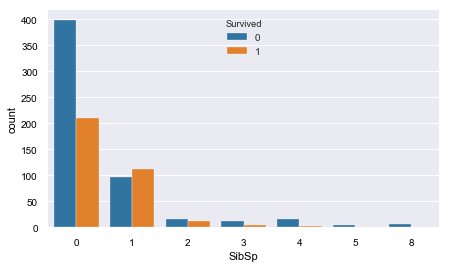

In [61]:
#sns.countplot()はマスターしよう！
# https://seaborn.pydata.org/generated/seaborn.countplot.html
plt.figure(figsize=(7,4))
sns.countplot(x="SibSp",hue="Survived",data=train)

In [62]:
#sns.crosstab()もマスターしよう！
pd.crosstab(columns=train["SibSp"],
             index=train["Survived"])

SibSp,0,1,2,3,4,5,8
Survived,,,,,,,
0,398,97,15,12,15,5,7
1,210,112,13,4,3,0,0


In [63]:
pd.crosstab(columns=train["SibSp"],
            index=train["Survived"],
            normalize="index")

SibSp,0,1,2,3,4,5,8
Survived,,,,,,,
0,0.724954,0.176685,0.027322,0.021858,0.027322,0.009107,0.01275
1,0.614035,0.327485,0.038012,0.011696,0.008772,0.000000,0.00000


(array([0, 1]), <a list of 2 Text xticklabel objects>)

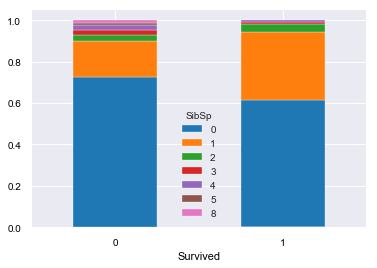

In [64]:
#sns.crosstab()はnormalizeで割合表示できる。さらに、plotでstacked=Trueにすると、「積み上げ棒グラフ」の完成。
pd.crosstab(columns=train["SibSp"],
            index=train["Survived"],
            normalize="index").plot(kind="bar",stacked=True)
plt.xticks(rotation=0)

↓stackedないと超見にくい

(array([0, 1]), <a list of 2 Text xticklabel objects>)

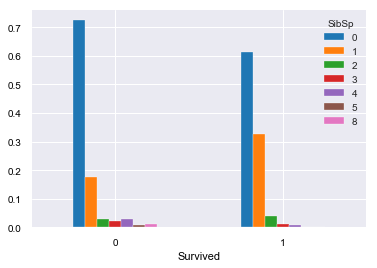

In [65]:
pd.crosstab(columns=train["SibSp"],
            index=train["Survived"],
            normalize="index").plot(kind="bar")
plt.xticks(rotation=0)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

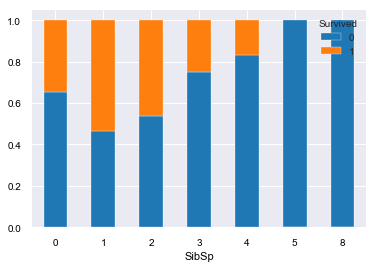

In [77]:
#indexとcolumnsを入れ替えると、Sibspごとの割合が見れる
pd.crosstab(index=train["SibSp"],
            columns=train["Survived"],
            normalize="index").plot(kind="bar",stacked=True)
plt.xticks(rotation=0)

#### Parchの生存カウント（タイタニックに同乗している親/子供の数）

Sibspと同じように、Parchもカウント

In [78]:
train["Parch"].nunique()

7

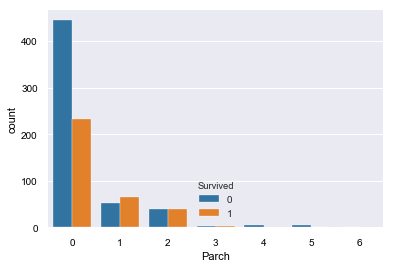

In [79]:
sns.countplot(x="Parch",hue="Survived",data=train)

In [80]:
pd.crosstab(columns=train["Parch"],
            index=train["Survived"])

Parch,0,1,2,3,4,5,6
Survived,,,,,,,
0,445,53,40,2,4,4,1
1,233,65,40,3,0,1,0


(array([0, 1]), <a list of 2 Text xticklabel objects>)

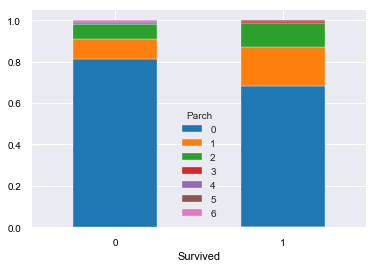

In [81]:
pd.crosstab(columns=train["Parch"],
            index=train["Survived"],
            normalize="index").plot(kind="bar",stacked=True)
plt.xticks(rotation=0)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

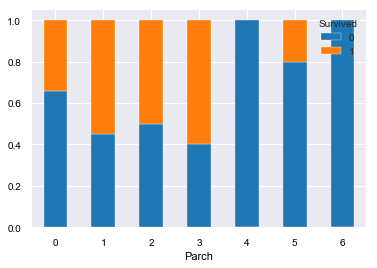

In [82]:
pd.crosstab(index=train["Parch"],
            columns=train["Survived"],
            normalize="index").plot(kind="bar",stacked=True)

plt.xticks(rotation=0)

#### Pclass別:min,max,mean,median,std

In [83]:
#先ずはPclassを分けていきます
tp1 = train[train['Pclass'] == 1]
tp2 = train[train['Pclass'] == 2]
tp3 = train[train['Pclass'] == 3]

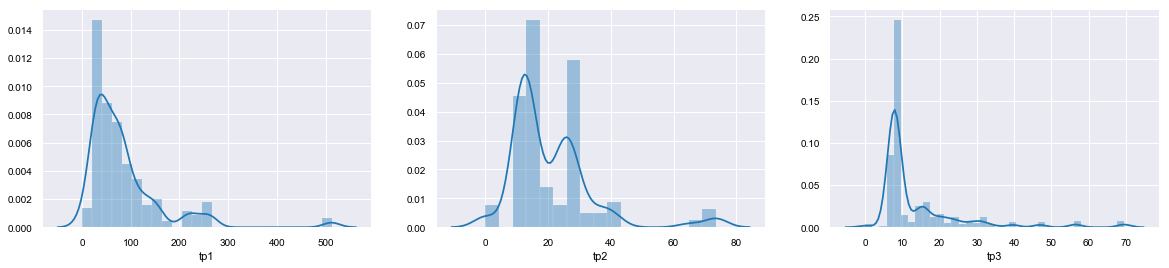

In [84]:
#それぞれのPclassごとのFare分布を見てみる
fig,(ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20, 4))
sns.distplot(tp1['Fare'], ax=ax1,axlabel='tp1')
sns.distplot(tp2['Fare'], ax=ax2,axlabel='tp2')
sns.distplot(tp3['Fare'], ax=ax3,axlabel='tp3')

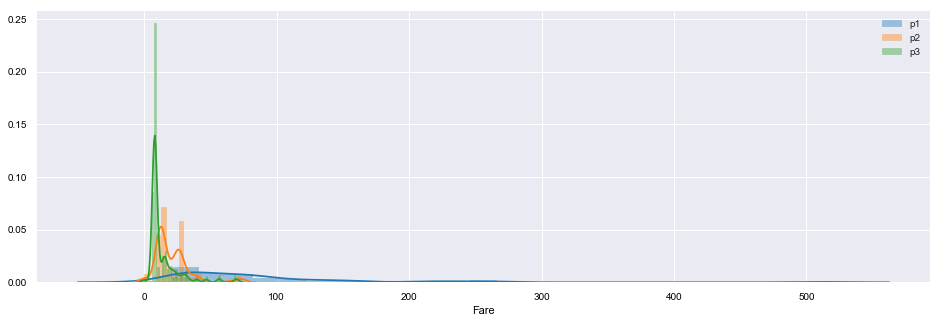

In [85]:
#一つにして表記するとこんな感じ！
plt.figure(figsize=(16, 5))
sns.distplot(tp1['Fare'], label='p1')
sns.distplot(tp2['Fare'], label='p2')
sns.distplot(tp3['Fare'], label='p3')
plt.legend();

In [86]:
train.groupby("Pclass").agg({"Fare":['min', 'max', 'mean', 'median', 'std']})

Fare                                         
        min       max       mean   median        std
Pclass                                              
1       0.0  512.3292  84.154687  60.2875  78.380373
2       0.0   73.5000  20.662183  14.2500  13.417399
3       0.0   69.5500  13.675550   8.0500  11.778142

In [87]:
train[train["Fare"]==0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,by_age
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S,"(30.0, 40.0]"
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S,"(30.0, 40.0]"
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S,"(20.0, 30.0]"
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S,NaN
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S,"(10.0, 20.0]"
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S,NaN
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S,NaN
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S,NaN
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S,"(40.0, 50.0]"
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S,NaN


### fareが０でな人を見てみましょ！

In [88]:
non_zero_fare_train = train[train["Fare"]!=0]

In [89]:
non_zero_fare_train.groupby("Pclass").agg({"Fare":['min', 'max', 'mean', 'median', 'std']})

Fare                                         
            min       max       mean   median        std
Pclass                                                  
1        5.0000  512.3292  86.148874  61.9792  78.212155
2       10.5000   73.5000  21.358661  15.0229  13.083169
3        4.0125   69.5500  13.787875   8.0500  11.760718

### Pclass別の生存割合

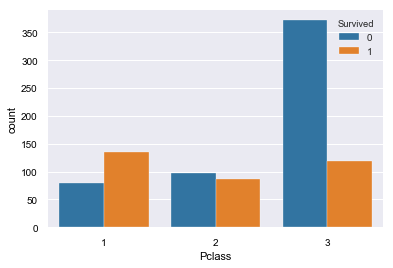

In [90]:
sns.countplot(x="Pclass",hue="Survived",data=train)

↑やはり３等客は亡くなりやすいっす

In [91]:
pd.crosstab(columns=train["Survived"],
            index=train["Pclass"])

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

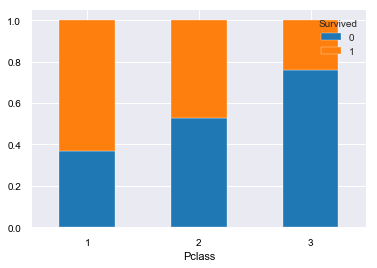

In [92]:
pd.crosstab(columns=train["Survived"],
            index=train["Pclass"],
            normalize="index").plot(kind="bar",stacked=True)

plt.xticks(rotation=0)

## 年齢と性別のdistplot

In [93]:
t0 = train[train['Survived'] == 0]
t1 = train[train['Survived'] == 1]

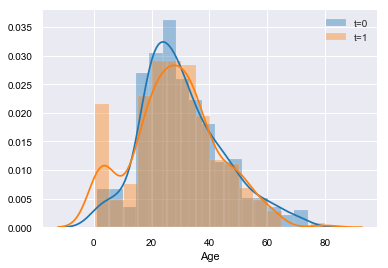

In [94]:
sns.distplot(t0['Age'].dropna(), label='t=0')
sns.distplot(t1['Age'].dropna(), label='t=1')
plt.legend();

In [95]:
p0 = train[train["Sex"]=="male"]
p1 = train[train["Sex"]=="female"]

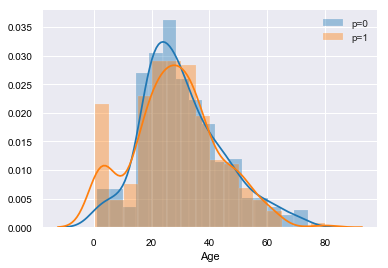

In [96]:
sns.distplot(t0["Age"].dropna(),label="p=0")
sns.distplot(t1["Age"].dropna(),label="p=1")
plt.legend()

# 家族連れの生存率を出してみるなり！！

In [97]:
train["Family_Size"] = train["Parch"] + train["SibSp"] + 1
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,by_age,Family_Size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,"(20.0, 30.0]",2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,"(30.0, 40.0]",2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,"(20.0, 30.0]",1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,"(30.0, 40.0]",2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,"(30.0, 40.0]",1
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,NaN,1
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,"(50.0, 60.0]",1
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,"(0.0, 10.0]",5
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,"(20.0, 30.0]",3
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,"(10.0, 20.0]",2


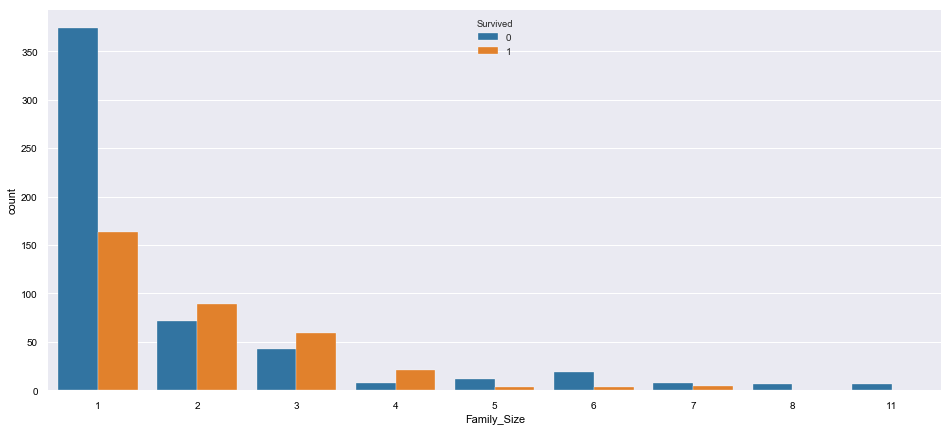

In [98]:
plt.figure(figsize=(16,7))
sns.countplot(x="Family_Size",data=train,hue="Survived")

### Family_Size >= 5で死亡しやすい。。。では、一人で来た人も見てみるとする

In [99]:
train["IsAlone"] = 0
train.loc[train["Family_Size"]==1,"IsAlone"] = 1
train.shape

(891, 15)

In [100]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,by_age,Family_Size,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,"(20.0, 30.0]",2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,"(30.0, 40.0]",2,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,"(20.0, 30.0]",1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,"(30.0, 40.0]",2,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,"(30.0, 40.0]",1,1
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,NaN,1,1
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,"(50.0, 60.0]",1,1
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,"(0.0, 10.0]",5,0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,"(20.0, 30.0]",3,0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,"(10.0, 20.0]",2,0


In [101]:
pd.crosstab(columns=train["Survived"],
            index=train["IsAlone"],
            margins=True)

Survived,0,1,All
IsAlone,,,
0,175,179,354
1,374,163,537
All,549,342,891


(array([0, 1]), <a list of 2 Text xticklabel objects>)

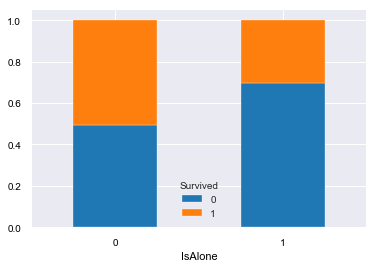

In [102]:
pd.crosstab(index=train["IsAlone"],
            columns=train["Survived"],
            normalize="index").plot(kind="bar",stacked=True)
plt.xticks(rotation=0)

## Name敬称抽出

In [103]:
train["Name"]

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
5                                       Moran, Mr. James
6                                McCarthy, Mr. Timothy J
7                         Palsson, Master. Gosta Leonard
8      Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                    Nasser, Mrs. Nicholas (Adele Achem)
10                       Sandstrom, Miss. Marguerite Rut
11                              Bonnell, Miss. Elizabeth
12                        Saundercock, Mr. William Henry
13                           Andersson, Mr. Anders Johan
14                  Vestrom, Miss. Hulda Amanda Adolfina
15                      Hewlett, Mrs. (Mary D Kingcome) 
16                                  Rice, Master. Eugene
17                          Wil

In [104]:
def split_char(df,s,num):
    df.str("s").str.get(num)

In [105]:
for s in {}:
    s_Name = split_char(train["Name"],s,-1)
    s_Name

In [106]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'by_age', 'Family_Size',
       'IsAlone'],
      dtype='object')

In [107]:
s_Name = train["Name"].str.split(",").str.get(-1).str.split(".").str.get(0).astype(str)
train["s_Name"] = s_Name.astype(str)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,by_age,Family_Size,IsAlone,s_Name
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,"(20, 30]",2,0,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,"(30, 40]",2,0,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,"(20, 30]",1,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,"(30, 40]",2,0,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,"(30, 40]",1,1,Mr


In [108]:
col_list = ['PassengerId','Survived','Pclass','Name',
 'Sex','Age','SibSp','Parch',
 'Ticket','Fare','Cabin','Embarked',
 'Family_Size','IsAlone','s_Name']
train=train[col_list]

In [109]:
train["s_Name"].str.len()

0      3
1      4
2      5
3      4
4      3
5      3
6      3
7      7
8      4
9      4
10     5
11     5
12     3
13     3
14     5
15     4
16     7
17     3
18     4
19     4
20     3
21     3
22     5
23     3
24     5
25     4
26     3
27     3
28     5
29     3
      ..
861    3
862    4
863    5
864    3
865    4
866    5
867    3
868    3
869    7
870    3
871    4
872    3
873    3
874    4
875    5
876    3
877    3
878    3
879    4
880    4
881    3
882    5
883    3
884    3
885    4
886    4
887    5
888    5
889    3
890    3
Name: s_Name, Length: 891, dtype: int64

In [110]:
train.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Family_Size',
       'IsAlone', 's_Name'], dtype=object)

In [111]:
pd.crosstab(columns=train["Survived"],
            index=train["s_Name"],
            margins=True)

Survived,0,1,All
s_Name,,,
Capt,1,0,1
Col,1,1,2
Don,1,0,1
Dr,4,3,7
Jonkheer,1,0,1
Lady,0,1,1
Major,1,1,2
Master,17,23,40
Miss,55,127,182


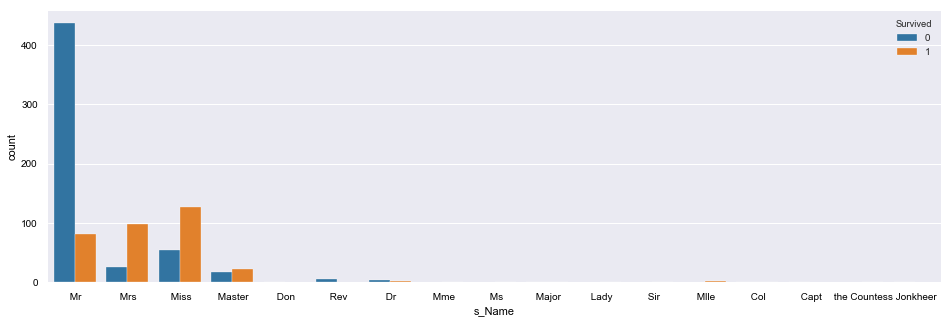

In [112]:
plt.figure(figsize=(16,5))
sns.countplot(x="s_Name",hue="Survived",data=train)

In [113]:
train["IsAlone"].value_counts()

1    537
0    354
Name: IsAlone, dtype: int64

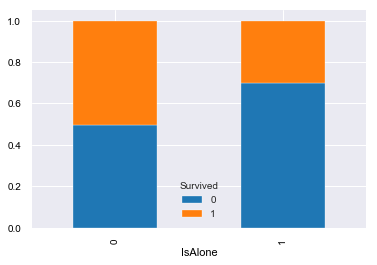

In [114]:
pd.crosstab(columns=train["Survived"],
            index=train["IsAlone"],
            normalize="index").plot(kind="bar",stacked=True)

In [115]:
pd.crosstab(columns=train["Survived"],
            index=train["s_Name"],
            normalize="index")

Survived,0,1
s_Name,,
Capt,1.000000,0.000000
Col,0.500000,0.500000
Don,1.000000,0.000000
Dr,0.571429,0.428571
Jonkheer,1.000000,0.000000
Lady,0.000000,1.000000
Major,0.500000,0.500000
Master,0.425000,0.575000
Miss,0.302198,0.697802


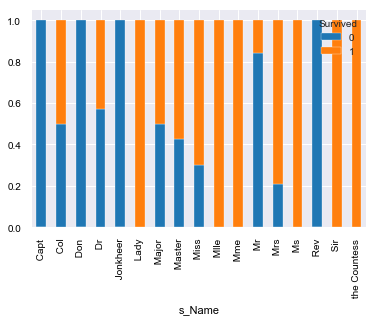

In [116]:
pd.crosstab(columns=train["Survived"],
            index=train["s_Name"],
            normalize="index").plot(kind="bar",stacked=True)

## ジャックの味方マーガレット夫人

In [117]:
train_Name_search = train[train["Name"].str.contains("Margaret Tobin") & train["Survived"]==1]
train_Name_search

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,IsAlone,s_Name
194,195,1,1,"Brown, Mrs. James Joseph (Margaret Tobin)",female,44.0,0,0,PC 17610,27.7208,B4,C,1,1,Mrs


In [118]:
train["s_Name"] = train["s_Name"].astype(str)
train["s_Name"].dtype

dtype('O')

In [119]:
train["s_Name"].str.contains("Mrs")

0      False
1       True
2      False
3       True
4      False
5      False
6      False
7      False
8       True
9       True
10     False
11     False
12     False
13     False
14     False
15      True
16     False
17     False
18      True
19      True
20     False
21     False
22     False
23     False
24     False
25      True
26     False
27     False
28     False
29     False
       ...  
861    False
862     True
863    False
864    False
865     True
866    False
867    False
868    False
869    False
870    False
871     True
872    False
873    False
874     True
875    False
876    False
877    False
878    False
879     True
880     True
881    False
882    False
883    False
884    False
885     True
886    False
887    False
888    False
889    False
890    False
Name: s_Name, Length: 891, dtype: bool

### Mr,Mrs,miss,masterの平均

In [120]:
mr_mean = train[(train["s_Name"].str.contains("Mr")) & (train["Sex"]=="male")]["Age"].mean()
mr_mean

32.368090452261306

In [121]:
mrs_mean = train[train["s_Name"].str.contains("Mrs")]["Age"].mean()
mrs_mean

35.898148148148145

In [122]:
miss_mean = train[train["s_Name"].str.contains("Miss")]["Age"].mean()
miss_mean

21.773972602739725

In [123]:
master_mean = train[train["s_Name"].str.contains("Master")]["Age"].mean()
master_mean

4.574166666666667

## これをAgeの欠損埋めにつかいましょう

In [124]:
kesson_table(train)

,lack num,%
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
Age,177,19.865320
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000
Fare,0,0.000000


In [125]:
null_train = train[train["Age"].isnull()]
pd.crosstab(columns=null_train["Sex"],
            index=null_train["s_Name"],
            margins="index")

Sex,female,male,All
s_Name,,,
Dr,0,1,1
Master,0,4,4
Miss,36,0,36
Mr,0,119,119
Mrs,17,0,17
All,53,124,177


In [126]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Family_Size      int64
IsAlone          int64
s_Name          object
dtype: object

In [127]:
mr_null = ~(~(train["s_Name"].str.contains("Master")) & (train["Sex"] == "male") & (train["Age"].isnull()))
mr_null

0       True
1       True
2       True
3       True
4       True
5      False
6       True
7       True
8       True
9       True
10      True
11      True
12      True
13      True
14      True
15      True
16      True
17     False
18      True
19      True
20      True
21      True
22      True
23      True
24      True
25      True
26     False
27      True
28      True
29     False
       ...  
861     True
862     True
863     True
864     True
865     True
866     True
867     True
868    False
869     True
870     True
871     True
872     True
873     True
874     True
875     True
876     True
877     True
878    False
879     True
880     True
881     True
882     True
883     True
884     True
885     True
886     True
887     True
888     True
889     True
890     True
Length: 891, dtype: bool

In [128]:
train["Age"] = train["Age"].where(mr_null,mr_mean)

In [129]:
mrs_null = ~((train["s_Name"].str.contains("Mrs")) & (train["Age"].isnull()))
mrs_null

0       True
1       True
2       True
3       True
4       True
5       True
6       True
7       True
8       True
9       True
10      True
11      True
12      True
13      True
14      True
15      True
16      True
17      True
18      True
19     False
20      True
21      True
22      True
23      True
24      True
25      True
26      True
27      True
28      True
29      True
       ...  
861     True
862     True
863     True
864     True
865     True
866     True
867     True
868     True
869     True
870     True
871     True
872     True
873     True
874     True
875     True
876     True
877     True
878     True
879     True
880     True
881     True
882     True
883     True
884     True
885     True
886     True
887     True
888     True
889     True
890     True
Length: 891, dtype: bool

In [130]:
train["Age"] = train["Age"].where(mrs_null,mrs_mean)

In [131]:
miss_null = ~((train["s_Name"].str.contains("Miss")) & (train["Age"].isnull()))
miss_null

0       True
1       True
2       True
3       True
4       True
5       True
6       True
7       True
8       True
9       True
10      True
11      True
12      True
13      True
14      True
15      True
16      True
17      True
18      True
19      True
20      True
21      True
22      True
23      True
24      True
25      True
26      True
27      True
28     False
29      True
       ...  
861     True
862     True
863    False
864     True
865     True
866     True
867     True
868     True
869     True
870     True
871     True
872     True
873     True
874     True
875     True
876     True
877     True
878     True
879     True
880     True
881     True
882     True
883     True
884     True
885     True
886     True
887     True
888    False
889     True
890     True
Length: 891, dtype: bool

In [132]:
train["Age"] = train["Age"].where(miss_null,miss_mean)

In [133]:
master_null = ~((train["s_Name"].str.contains("Master")) & (train["Age"].isnull()))
master_null

0      True
1      True
2      True
3      True
4      True
5      True
6      True
7      True
8      True
9      True
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19     True
20     True
21     True
22     True
23     True
24     True
25     True
26     True
27     True
28     True
29     True
       ... 
861    True
862    True
863    True
864    True
865    True
866    True
867    True
868    True
869    True
870    True
871    True
872    True
873    True
874    True
875    True
876    True
877    True
878    True
879    True
880    True
881    True
882    True
883    True
884    True
885    True
886    True
887    True
888    True
889    True
890    True
Length: 891, dtype: bool

In [134]:
train["Age"] = train["Age"].where(master_null,master_mean)

In [135]:
kesson_table(train)

,lack num,%
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
Age,0,0.000000
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000
Fare,0,0.000000


.apply()
.map()
今度Markdownで書いてみよう

In [136]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,IsAlone,s_Name
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,2,0,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,2,0,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,2,0,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,1,1,Mr
5,6,0,3,"Moran, Mr. James",male,32.368090,0,0,330877,8.4583,NaN,Q,1,1,Mr
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,17463,51.8625,E46,S,1,1,Mr
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.0750,NaN,S,5,0,Master
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,0,2,347742,11.1333,NaN,S,3,0,Mrs
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.000000,1,0,237736,30.0708,NaN,C,2,0,Mrs


In [137]:
kesson_table(train)

,lack num,%
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
Age,0,0.000000
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000
Fare,0,0.000000
